## **IMPORT PACKAGES**

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import os
#VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## **READING RAW DATA FROM CSV FILES**

We only have taking into account for this project the traffic data from January to August. There are a zip file for each month inside of *InputData* folder

In [2]:
%%time
df_list = []
source='/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data/Historico/InputData/'

for file in os.listdir(source):
    df_aux = pd.read_csv(source+file,sep=';')
    df_list.append(df_aux)

df = pd.concat(df_list, axis=0, ignore_index=True)
#df = df.append([df for df in df_list],ignore_index=True)
#df.to_csv('final.csv', index=False)

CPU times: user 1min 59s, sys: 37 s, total: 2min 36s
Wall time: 2min 35s


In [3]:
df.shape

(89858302, 9)

## **DATA PREPARATION**

**1. Formating "Fecha" Column and splitting it on "Date" and "Hora"**

In [4]:
%%time
df['fecha']=pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df['Fecha']=df["fecha"].dt.date
#Creating new columns spiltting Date and Hour of the day.
df['Hora']=df["fecha"].dt.time
df["Date"]=df["fecha"]
#Drop original column fecha
df = df.drop('fecha', 1)

CPU times: user 2min 5s, sys: 2min 20s, total: 4min 26s
Wall time: 4min 55s


In [5]:
df.dtypes

id                              int64
tipo_elem                      object
intensidad                      int64
ocupacion                       int64
carga                           int64
vmed                            int64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
dtype: object

**2. Obtaining X e Y UTM coordinates from others files**

Finally, we only keep in mind points measuremente places on the last month registed. By this way, we filer only for the points that they are currently working. These are only the interested ones for us.

The file has different encoding of the default ones, for doing the load we need to specify the encoding and the decimal number point delimiter.

In [6]:
sourceMP='/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data/HistoricoPuntosMedidaUbic/pmed_ubicacion_09_2018.csv'
dfplaces=pd.read_csv(sourceMP,sep=';',encoding='ISO-8859-1',decimal=",")

In [7]:
dfplaces.dtypes

tipo_elem     object
id             int64
cod_cent      object
nombre        object
x            float64
y            float64
dtype: object

**3. Transforming Coordinates from UTM to Latitude and Longitude.**

Code function source: https://stackoverflow.com/questions/343865/how-to-convert-from-utm-to-latlng-in-python-or-javascript

Modifications: 
 - Madrid zone value: 30
 - Values returned like a list of float64

In [8]:
def utmToLatLng(easting, northing, northernHemisphere=True,zone=30):
    #Defining default Madrid zone with the value: 30
    if not northernHemisphere:
        northing = 10000000 - northing

    a = 6378137
    e = 0.081819191
    e1sq = 0.006739497
    k0 = 0.9996

    arc = northing / k0
    mu = arc / (a * (1 - math.pow(e, 2) / 4.0 - 3 * math.pow(e, 4) / 64.0 - 5 * math.pow(e, 6) / 256.0))

    ei = (1 - math.pow((1 - e * e), (1 / 2.0))) / (1 + math.pow((1 - e * e), (1 / 2.0)))

    ca = 3 * ei / 2 - 27 * math.pow(ei, 3) / 32.0

    cb = 21 * math.pow(ei, 2) / 16 - 55 * math.pow(ei, 4) / 32
    cc = 151 * math.pow(ei, 3) / 96
    cd = 1097 * math.pow(ei, 4) / 512
    phi1 = mu + ca * math.sin(2 * mu) + cb * math.sin(4 * mu) + cc * math.sin(6 * mu) + cd * math.sin(8 * mu)

    n0 = a / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (1 / 2.0))

    r0 = a * (1 - e * e) / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (3 / 2.0))
    fact1 = n0 * math.tan(phi1) / r0

    _a1 = 500000 - easting
    dd0 = _a1 / (n0 * k0)
    fact2 = dd0 * dd0 / 2

    t0 = math.pow(math.tan(phi1), 2)
    Q0 = e1sq * math.pow(math.cos(phi1), 2)
    fact3 = (5 + 3 * t0 + 10 * Q0 - 4 * Q0 * Q0 - 9 * e1sq) * math.pow(dd0, 4) / 24

    fact4 = (61 + 90 * t0 + 298 * Q0 + 45 * t0 * t0 - 252 * e1sq - 3 * Q0 * Q0) * math.pow(dd0, 6) / 720

    lof1 = _a1 / (n0 * k0)
    lof2 = (1 + 2 * t0 + Q0) * math.pow(dd0, 3) / 6.0
    lof3 = (5 - 2 * Q0 + 28 * t0 - 3 * math.pow(Q0, 2) + 8 * e1sq + 24 * math.pow(t0, 2)) * math.pow(dd0, 5) / 120
    _a2 = (lof1 - lof2 + lof3) / math.cos(phi1)
    _a3 = _a2 * 180 / math.pi

    latitude = 180 * (phi1 - fact1 * (fact2 + fact3 + fact4)) / math.pi

    if not northernHemisphere:
        latitude = -latitude

    longitude = ((zone > 0) and (6 * zone - 183.0) or 3.0) - _a3

    return [latitude, longitude]

In [9]:
%%time
dfplaces['LatLong'] = dfplaces.apply(lambda x: utmToLatLng(x['x'], x['y']), axis=1)

CPU times: user 225 ms, sys: 13.7 ms, total: 239 ms
Wall time: 256 ms


In [10]:
%%time
dfplaces[['Lat','Long']] = pd.DataFrame(dfplaces.LatLong.values.tolist(), index= dfplaces.index)

CPU times: user 4.54 ms, sys: 2.41 ms, total: 6.96 ms
Wall time: 8.76 ms


In [11]:
dfplaces=dfplaces.drop(columns=['LatLong'])

In [12]:
dfplaces.head()

,tipo_elem,id,cod_cent,nombre,x,y,Lat,Long
0,URB,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,40.430502,-3.688323
1,URB,3841,01002,Jose Ortega y Gasset O-E - Serrano-Pº Castellana,441705.882340,4.475770e+06,40.430524,-3.687256
2,URB,3842,01003,Pº Recoletos N-S - Almirante-Prim,441319.371258,4.474841e+06,40.422132,-3.691727
3,URB,3843,01004,"Pº Recoletos S-N - Pl, Cibeles- Recoletos",441301.632986,4.474764e+06,40.421433,-3.691929
4,URB,3844,01005,(AFOROS) Pº Castellana S-N - Eduardo Dato - P...,441605.765072,4.476132e+06,40.433782,-3.688470


**4. Adding Latitude and Longitude to the main dataframe.**

In [13]:
%%time
df_complete=df.join(dfplaces.set_index('id')[['Lat','Long']],on='id',how='left',rsuffix='_other')

CPU times: user 24.5 s, sys: 40 s, total: 1min 4s
Wall time: 1min 19s


In [14]:
df_complete.dtypes

id                              int64
tipo_elem                      object
intensidad                      int64
ocupacion                       int64
carga                           int64
vmed                            int64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
Lat                           float64
Long                          float64
dtype: object

In [15]:
df_complete.head()

,id,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,Fecha,Hora,Date,Lat,Long
0,1001,PUNTOS MEDIDA M-30,204,12,0,73,N,5,2018-01-01,00:00:00,2018-01-01,40.409729,-3.740786
1,1002,PUNTOS MEDIDA M-30,252,1,0,79,N,5,2018-01-01,00:00:00,2018-01-01,40.408029,-3.743760
2,1003,PUNTOS MEDIDA M-30,420,2,0,82,N,5,2018-01-01,00:00:00,2018-01-01,40.406824,-3.746834
3,1006,PUNTOS MEDIDA M-30,288,1,0,75,N,5,2018-01-01,00:00:00,2018-01-01,40.411894,-3.736324
4,1009,PUNTOS MEDIDA M-30,276,0,0,76,N,5,2018-01-01,00:00:00,2018-01-01,40.416233,-3.724909


**5. Dealing columns with missing values**

In [16]:
%%time
df_complete.isnull().any()

CPU times: user 1min 13s, sys: 1min 56s, total: 3min 10s
Wall time: 3min 45s


id                     False
tipo_elem              False
intensidad             False
ocupacion              False
carga                  False
vmed                   False
error                  False
periodo_integracion    False
Fecha                  False
Hora                   False
Date                   False
Lat                     True
Long                    True
dtype: bool

In [17]:
nan_rows = df_complete[df_complete['Lat'].isnull()]
nan_rows.shape

(201965, 13)

In [18]:
df_complete.shape

(89858302, 13)

201.965 rows cointain missing values of 89.858.302 Total Values (0,22%). In this first approach, we will drop them.

We can not identify the location of these sensors because all of its measures are with null coordenates (generated in the crossing process to obtain Lat and Long due to old sensors that currently have dissapeared). These sensors has been checked in Measurement Points Dataset where information of the different Measurement Point are collected and classified. For these cases, no information about them has been found. At this point, we have decided to role out all of them (better option taking into account the proportion of missing values according to the total).

In [19]:
%%time
df_complete=df_complete.dropna(axis=0)

CPU times: user 1min, sys: 1min 35s, total: 2min 36s
Wall time: 3min 14s


In [20]:
df_complete.shape

(89656337, 13)

In [21]:
%%time
df_complete.isnull().any()

CPU times: user 37.9 s, sys: 34.5 s, total: 1min 12s
Wall time: 1min 27s


id                     False
tipo_elem              False
intensidad             False
ocupacion              False
carga                  False
vmed                   False
error                  False
periodo_integracion    False
Fecha                  False
Hora                   False
Date                   False
Lat                    False
Long                   False
dtype: bool

**6. Homogenizing values that are different because come from different files.**

An example of this is that feature 'tipo_elem' contains different names from one files to anothers. To homogenize this feature, we apply a function to map it in a uniform way.

In [22]:
def tp_uniform(tp):
    if (tp=='PUNTOS MEDIDA M-30' or tp=='M30'):
        return 'M30'
    else:
        return 'URB'

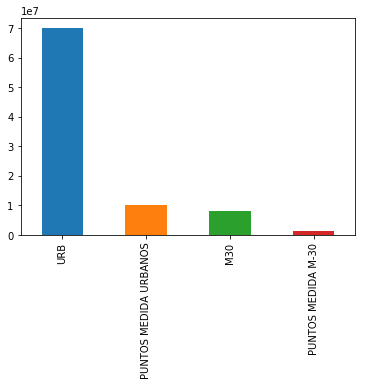

In [23]:
# Before applying the function. Histograms based on the categories.
df_complete['tipo_elem'].value_counts().plot(kind='bar')

Applying the defined function to all the column to mapping homogeneous values.

In [24]:
%%time
df_complete['tipo_elem'] = df_complete['tipo_elem'].apply(tp_uniform)

CPU times: user 23.8 s, sys: 1.38 s, total: 25.2 s
Wall time: 25.4 s


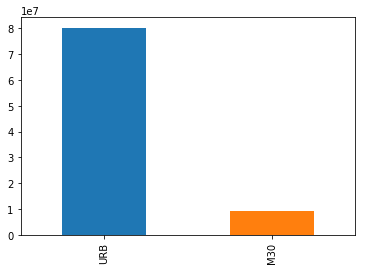

In [25]:
# After applying the function. Histograms based on the categories. 
df_complete['tipo_elem'].value_counts().plot(kind='bar')

**7. Dealing with wrong values**

According to the data source:

   * a) *"En el caso de M30, si la velocidad media es “0” junto con el resto de datos es por ser un horario y una vía por la que no ha pasado ningún vehículo en ese periodo de tiempo. Sin embargo, si hay datos en intensidad u ocupación y la velocidad media es “0”, podría ser un error en la toma de datos por un fallo en el detector, un desfase horario o un fallo en el lazo electromagnético."*


   * b) *"Para campos de vmed, intensidad y ocupación, si el valor es -1 implica la ausencia de datos.*

In [26]:
%%time
condition=(df_complete['vmed'] == 0) & ((df_complete['intensidad']!=0) | (df_complete['ocupacion']!=0))
df_complete_2=df_complete.drop(df_complete[condition].index)

CPU times: user 45.5 s, sys: 1min 40s, total: 2min 25s
Wall time: 3min 17s


In [27]:
%%time
df_complete_3=df_complete_2.drop(df_complete_2[df_complete_2['vmed']<0].index)

CPU times: user 4.59 s, sys: 8.74 s, total: 13.3 s
Wall time: 16.7 s


Relating to a) case, we will drop these registers. Once we have a model for applying, we will want to improve it for example inputing them, between other actions.

In [28]:
df_complete_3.shape

(10274183, 13)

Talking about b) case, if we would have "intensidad", "ocupacion", "carga" or "vmed" taking negative values, it means that these are incorrect registers so we will drop it.

In [29]:
df_complete_3.describe()

,id,intensidad,ocupacion,carga,vmed,periodo_integracion,Lat,Long
count,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07
mean,5.971502e+03,1.169725e+03,5.031878e+00,2.249205e+01,5.836161e+01,1.195411e+01,4.042927e+01,-3.692294e+00
std,2.272190e+03,1.328800e+03,7.013749e+00,2.753206e+01,2.789914e+01,4.609629e+00,3.692234e-02,3.423339e-02
min,1.001000e+03,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.033245e+01,-3.836943e+00
25%,4.746000e+03,1.560000e+02,0.000000e+00,0.000000e+00,4.600000e+01,5.000000e+00,4.039897e+01,-3.719845e+00
50%,6.733000e+03,6.570000e+02,3.000000e+00,8.000000e+00,6.500000e+01,1.500000e+01,4.041831e+01,-3.686571e+00
75%,6.868000e+03,1.788000e+03,7.000000e+00,4.100000e+01,7.900000e+01,1.500000e+01,4.046198e+01,-3.664111e+00
max,1.034300e+04,1.420800e+04,1.000000e+02,1.000000e+02,2.370000e+02,1.600000e+01,4.051561e+01,-3.580713e+00


In [30]:
%%time
df_complete_4=df_complete_3.drop(df_complete_3[df_complete_3['ocupacion']<0].index)

CPU times: user 3.57 s, sys: 4.93 s, total: 8.51 s
Wall time: 9.17 s


In [31]:
df_complete_4.shape

(10090919, 13)

Quick look to the features distribution and correlations.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f5068d0>,
      dtype=object)

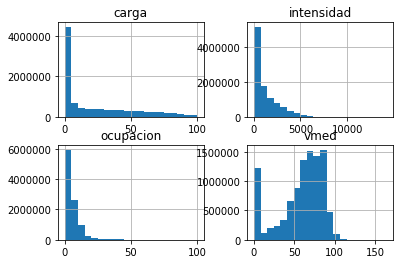

In [32]:
df_complete_4[['intensidad','ocupacion','vmed','carga']].hist(bins=20)

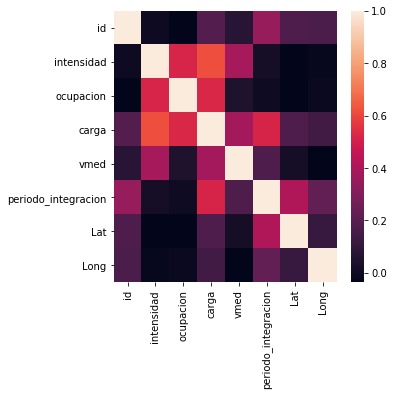

In [33]:
plt.figure(figsize=(5,5))
sns.heatmap(df_complete_4.corr())

**8. Looking for Outliers**

- *Visual Approach*

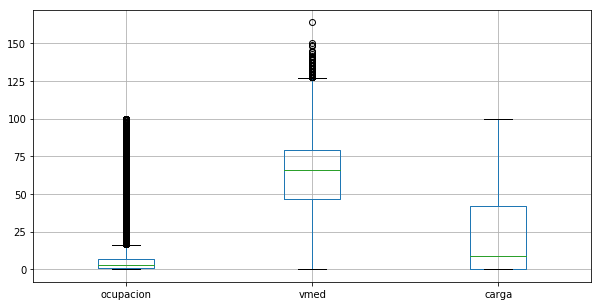

In [34]:
df_complete_4.boxplot(column=['ocupacion','vmed','carga'], grid=True, figsize=(10,5))

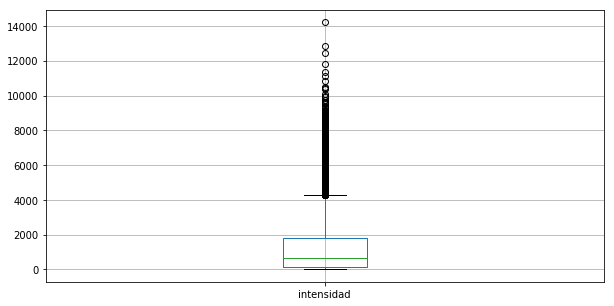

In [35]:
df_complete_4.boxplot(column=['intensidad'], grid=True, figsize=(10,5))

We can see some clear values that are out of range for 'vmed'. For 'intensidad' and 'ocupacion' there are a lot, but in this case it is not clear that these ones could be outliers. For now, we work with them.

- *Cuantitative Approach*

*The Z-score, or standard score, is a way of describing a data point in terms of its relationship to the mean and standard deviation of a group of points. Taking a Z-score is simply mapping the data onto a distribution whose mean is defined as 0 and whose standard deviation is defined as 1.*

*The goal of taking Z-scores is to remove the effects of the location and scale of the data, allowing different datasets to be compared directly. The intuition behind the Z-score method of outlier detection is that, once we’ve centred and rescaled the data, anything that is too far from zero (the threshold is usually a Z-score of 3 or -3) should be considered an outlier.*

Source: http://colingorrie.github.io/outlier-detection.html

In [36]:
%%time
#Copy the dataframe in other variable
df_complete_5=df_complete_4
#Iterate over the columns and create a new zscore column for Intensidad, Ocupacion, Carga y vmed.
for col in df_complete_5.columns:
    if col in ('vmed','carga','ocupacion','intensidad'):
        col_zscore = col + '_zscore'
        #Z-score:
        df_complete_5[col_zscore] = (df_complete_5[col] - df_complete_5[col].mean())/df_complete_5[col].std(ddof=0)

CPU times: user 825 ms, sys: 106 ms, total: 931 ms
Wall time: 418 ms


In [37]:
df_complete_5.dtypes

id                              int64
tipo_elem                      object
intensidad                      int64
ocupacion                       int64
carga                           int64
vmed                            int64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
Lat                           float64
Long                          float64
intensidad_zscore             float64
ocupacion_zscore              float64
carga_zscore                  float64
vmed_zscore                   float64
dtype: object

Showing outliers from z-score computed column. A sample can be considered outliers when its value set out of the range [-3,3]

In [38]:
threshold=3
#Intensidad
i=df_complete_5[np.abs(df_complete_5['intensidad_zscore']) > threshold].shape[0]
print("-Intensidad Outliers according to its Zscore out of [-3,3] range: {}\n".format(i))
#Ocupacion
o=df_complete_5[np.abs(df_complete_5['ocupacion_zscore']) > threshold].shape[0]
print("-Ocupacion Outliers according to its Zscore out of [-3,3] range: {}\n".format(o))
#Intensidad
c=df_complete_5[np.abs(df_complete_5['carga_zscore']) > threshold].shape[0]
print("-Carga Outliers according to its Zscore out of [-3,3] range: {}\n".format(c))
#Intensidad
v=df_complete_5[np.abs(df_complete_5['vmed_zscore']) > threshold].shape[0]
print("-Vmed Outliers according to its Zscore out of [-3,3] range: {}".format(v))

-Intensidad Outliers according to its Zscore out of [-3,3] range: 147623

-Ocupacion Outliers according to its Zscore out of [-3,3] range: 213037

-Carga Outliers according to its Zscore out of [-3,3] range: 0

-Vmed Outliers according to its Zscore out of [-3,3] range: 8


**9. One Hot Encoding for categorical features**

We have 2 categorical features: *"Tipo_elem"* and *"error"*

In [39]:
%%time
df1=pd.get_dummies(df_complete_5['tipo_elem'])
df2=pd.get_dummies(df_complete_5['error'])

CPU times: user 1.11 s, sys: 244 ms, total: 1.36 s
Wall time: 1.13 s


In [40]:
%time
df_complete_6=df_complete_5.merge(df1,left_index=True,right_index=True)
df_complete_6=df_complete_6.merge(df2,left_index=True,right_index=True)

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 10.3 µs


In [41]:
df_complete_6.head()

,id,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,Fecha,Hora,Date,Lat,Long,intensidad_zscore,ocupacion_zscore,carga_zscore,vmed_zscore,M30,URB,N
0,1001,M30,204,12,0,73,N,5,2018-01-01,00:00:00,2018-01-01,40.409729,-3.740786,-0.739126,0.975690,-0.829367,0.517939,1,0,1
1,1002,M30,252,1,0,79,N,5,2018-01-01,00:00:00,2018-01-01,40.408029,-3.743760,-0.703113,-0.589153,-0.829367,0.732259,1,0,1
2,1003,M30,420,2,0,82,N,5,2018-01-01,00:00:00,2018-01-01,40.406824,-3.746834,-0.577067,-0.446894,-0.829367,0.839419,1,0,1
3,1006,M30,288,1,0,75,N,5,2018-01-01,00:00:00,2018-01-01,40.411894,-3.736324,-0.676103,-0.589153,-0.829367,0.589379,1,0,1
4,1009,M30,276,0,0,76,N,5,2018-01-01,00:00:00,2018-01-01,40.416233,-3.724909,-0.685106,-0.731411,-0.829367,0.625099,1,0,1


In [42]:
df_complete_6.dtypes

id                              int64
tipo_elem                      object
intensidad                      int64
ocupacion                       int64
carga                           int64
vmed                            int64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
Lat                           float64
Long                          float64
intensidad_zscore             float64
ocupacion_zscore              float64
carga_zscore                  float64
vmed_zscore                   float64
M30                             uint8
URB                             uint8
N                               uint8
dtype: object

-------------

## **BREAK TO SAVE DATA FOR VISUALIZATIONS**

In [43]:
%%time
df_complete_6.to_csv('/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data-Science-Master-project/DATA/traffic_data_complete_visualizations.csv',index=False)

CPU times: user 4min 1s, sys: 8.21 s, total: 4min 9s
Wall time: 4min 17s


-------------

**10. Splitting and adapting *"Date"* feature in separated fields in order to adecuate data to Machine Learning Algorithm**

In [44]:
%%time
#Parsing Date feature to string in order to split it
df_complete_6['Date'] = df_complete_6['Date'].astype(str)

CPU times: user 14.2 s, sys: 830 ms, total: 15 s
Wall time: 14.9 s


In [45]:
type(df_complete_6['Date'][0])

str

In [46]:
%%time
df_complete_6['FechaAUX'], df_complete_6['HoraAUX'] = df_complete_6['Date'].str.split(' ', 1).str
df_complete_6['Anio'], df_complete_6['Mes'], df_complete_6['Dia'] = df_complete_6['FechaAUX'].str.split('-', 2).str
df_complete_6['Hora'], df_complete_6['Minutos'], df_complete_6['Segundos']= df_complete_6['HoraAUX'].str.split(':', 2).str

CPU times: user 2min 12s, sys: 13.8 s, total: 2min 26s
Wall time: 2min 24s


Dropping unusable and auxiliar columns including "Segundos" due to its value is always 00.

In [47]:
df_complete_6=df_complete_6.drop(['FechaAUX','HoraAUX','Date','Segundos'],axis=1)

Casting to integer for generated columns

In [48]:
df_complete_6 = df_complete_6.astype({"Anio": int, "Mes": int, "Dia": int, "Hora": int, "Minutos": int})

In [49]:
df_complete_6.dtypes

id                       int64
tipo_elem               object
intensidad               int64
ocupacion                int64
carga                    int64
vmed                     int64
error                   object
periodo_integracion      int64
Fecha                   object
Hora                     int64
Lat                    float64
Long                   float64
intensidad_zscore      float64
ocupacion_zscore       float64
carga_zscore           float64
vmed_zscore            float64
M30                      uint8
URB                      uint8
N                        uint8
Anio                     int64
Mes                      int64
Dia                      int64
Minutos                  int64
dtype: object

**11. Cleaning-up the complete dataframe (Dropping auxiliar columns, original columns encoded, etc)**

Correlation between features

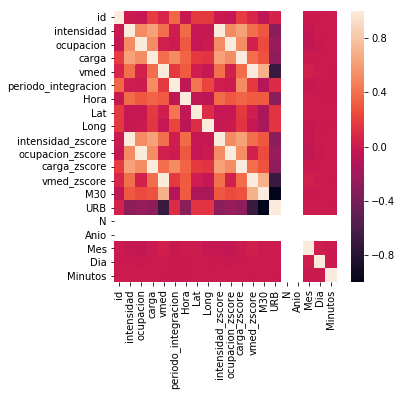

In [50]:
plt.figure(figsize=(5,5))
sns.heatmap(df_complete_6.corr())

Dropping columns without information in our dataset because it has a constant value for all rows.
These are "error" an "Anio". "Error" has always N value and for this case we only have data for 2018, so Anio is constant.

In [51]:
df_complete_7=df_complete_6.drop(columns=['N','Anio'])

In [52]:
df_complete_7.dtypes

id                       int64
tipo_elem               object
intensidad               int64
ocupacion                int64
carga                    int64
vmed                     int64
error                   object
periodo_integracion      int64
Fecha                   object
Hora                     int64
Lat                    float64
Long                   float64
intensidad_zscore      float64
ocupacion_zscore       float64
carga_zscore           float64
vmed_zscore            float64
M30                      uint8
URB                      uint8
Mes                      int64
Dia                      int64
Minutos                  int64
dtype: object

We plan to use decision tree algorithms in our project in order to make traffic load predictions. In spite of decision tree based algorithms are robust to outliers as the theory said, it is a non direct and easy issue. That these models would be robust does not mean that they would be entirely immune. In this particular case, **we have decided to remove outliers detected with Z-Score** for making lighter the modeling process considering the great amount of data that we manage.

To do this, we are going to use the outliers detection by Z-score method exposed above.

In [53]:
%%time
threshold=3
df_complete_7=df_complete_7.drop(df_complete_7[np.abs(df_complete_7['intensidad_zscore']) > threshold].index)
df_complete_7=df_complete_7.drop(df_complete_7[np.abs(df_complete_7['ocupacion_zscore']) > threshold].index)
df_complete_7=df_complete_7.drop(df_complete_7[np.abs(df_complete_7['carga_zscore']) > threshold].index)
df_complete_7=df_complete_7.drop(df_complete_7[np.abs(df_complete_7['vmed_zscore']) > threshold].index)

CPU times: user 15.4 s, sys: 11.9 s, total: 27.3 s
Wall time: 29.9 s


In [54]:
df_complete_7.shape

(9740545, 21)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x23ca260860>,
      dtype=object)

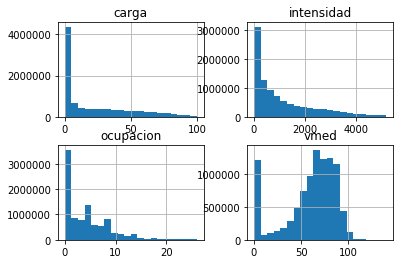

In [55]:
df_complete_7[['intensidad','ocupacion','vmed','carga']].hist(bins=20)

Dropping irrelevant columns for modeling

In [56]:
final_df=df_complete_7.drop(columns=['tipo_elem','error','Fecha','intensidad_zscore','ocupacion_zscore',
                                     'carga_zscore','vmed_zscore'])

In [57]:
final_df.dtypes

id                       int64
intensidad               int64
ocupacion                int64
carga                    int64
vmed                     int64
periodo_integracion      int64
Hora                     int64
Lat                    float64
Long                   float64
M30                      uint8
URB                      uint8
Mes                      int64
Dia                      int64
Minutos                  int64
dtype: object

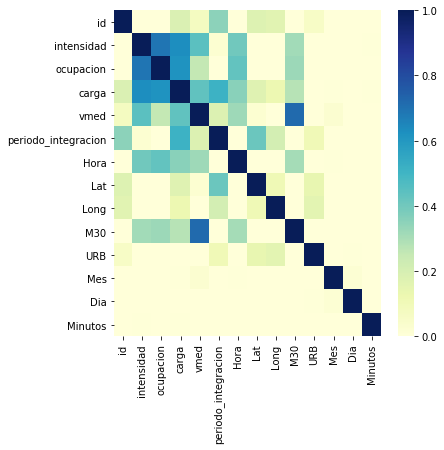

In [58]:
plt.figure(figsize=(6,6))
sns.heatmap(final_df.corr(),vmin=0,vmax=1,cmap="YlGnBu")
#we change the color map and it scale in order to observe better the correlations

## **SAVING FINAL DATA**

Saving complete processed traffic data

In [59]:
%%time
final_df.to_csv('/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data-Science-Master-project/DATA/traffic_data_complete.csv',index=False)

CPU times: user 2min 49s, sys: 3.24 s, total: 2min 53s
Wall time: 2min 54s
